In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sm = pd.read_csv("/content/syp-16-data.csv")
sm.head()

,Facebook,Twitter,LinkedIn,Google+,Youtube,Pinterest,Instagram,Tumblr,Flickr,Snapchat,WhatsApp,Vine,Periscope,Viber,KikMessenger,Telegram,ooVoo,YikYak,Other,Age
0,1,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,HS
1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,HS
2,1,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,Adult
3,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Adult
4,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,HS


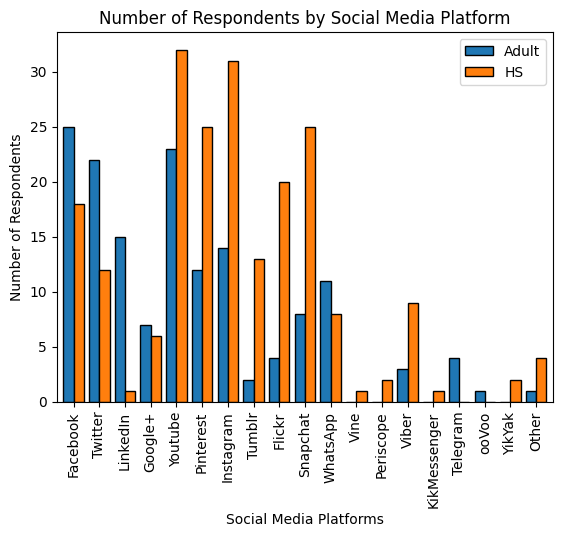

In [ ]:
Grouping = sm.groupby('Age').sum().T # Grouping data by age and calculating the sum of respondents for each social media platform
Grouping.plot(kind='bar',width=0.8,edgecolor='black') #Plotting the transposed DataFrame as a bar chart
plt.title('Number of Respondents by Social Media Platform') # setting title
plt.xlabel('Social Media Platforms') #giving x label
plt.ylabel('Number of Respondents') #giving y labe
plt.legend() #Adding legend to the plot
plt.show()

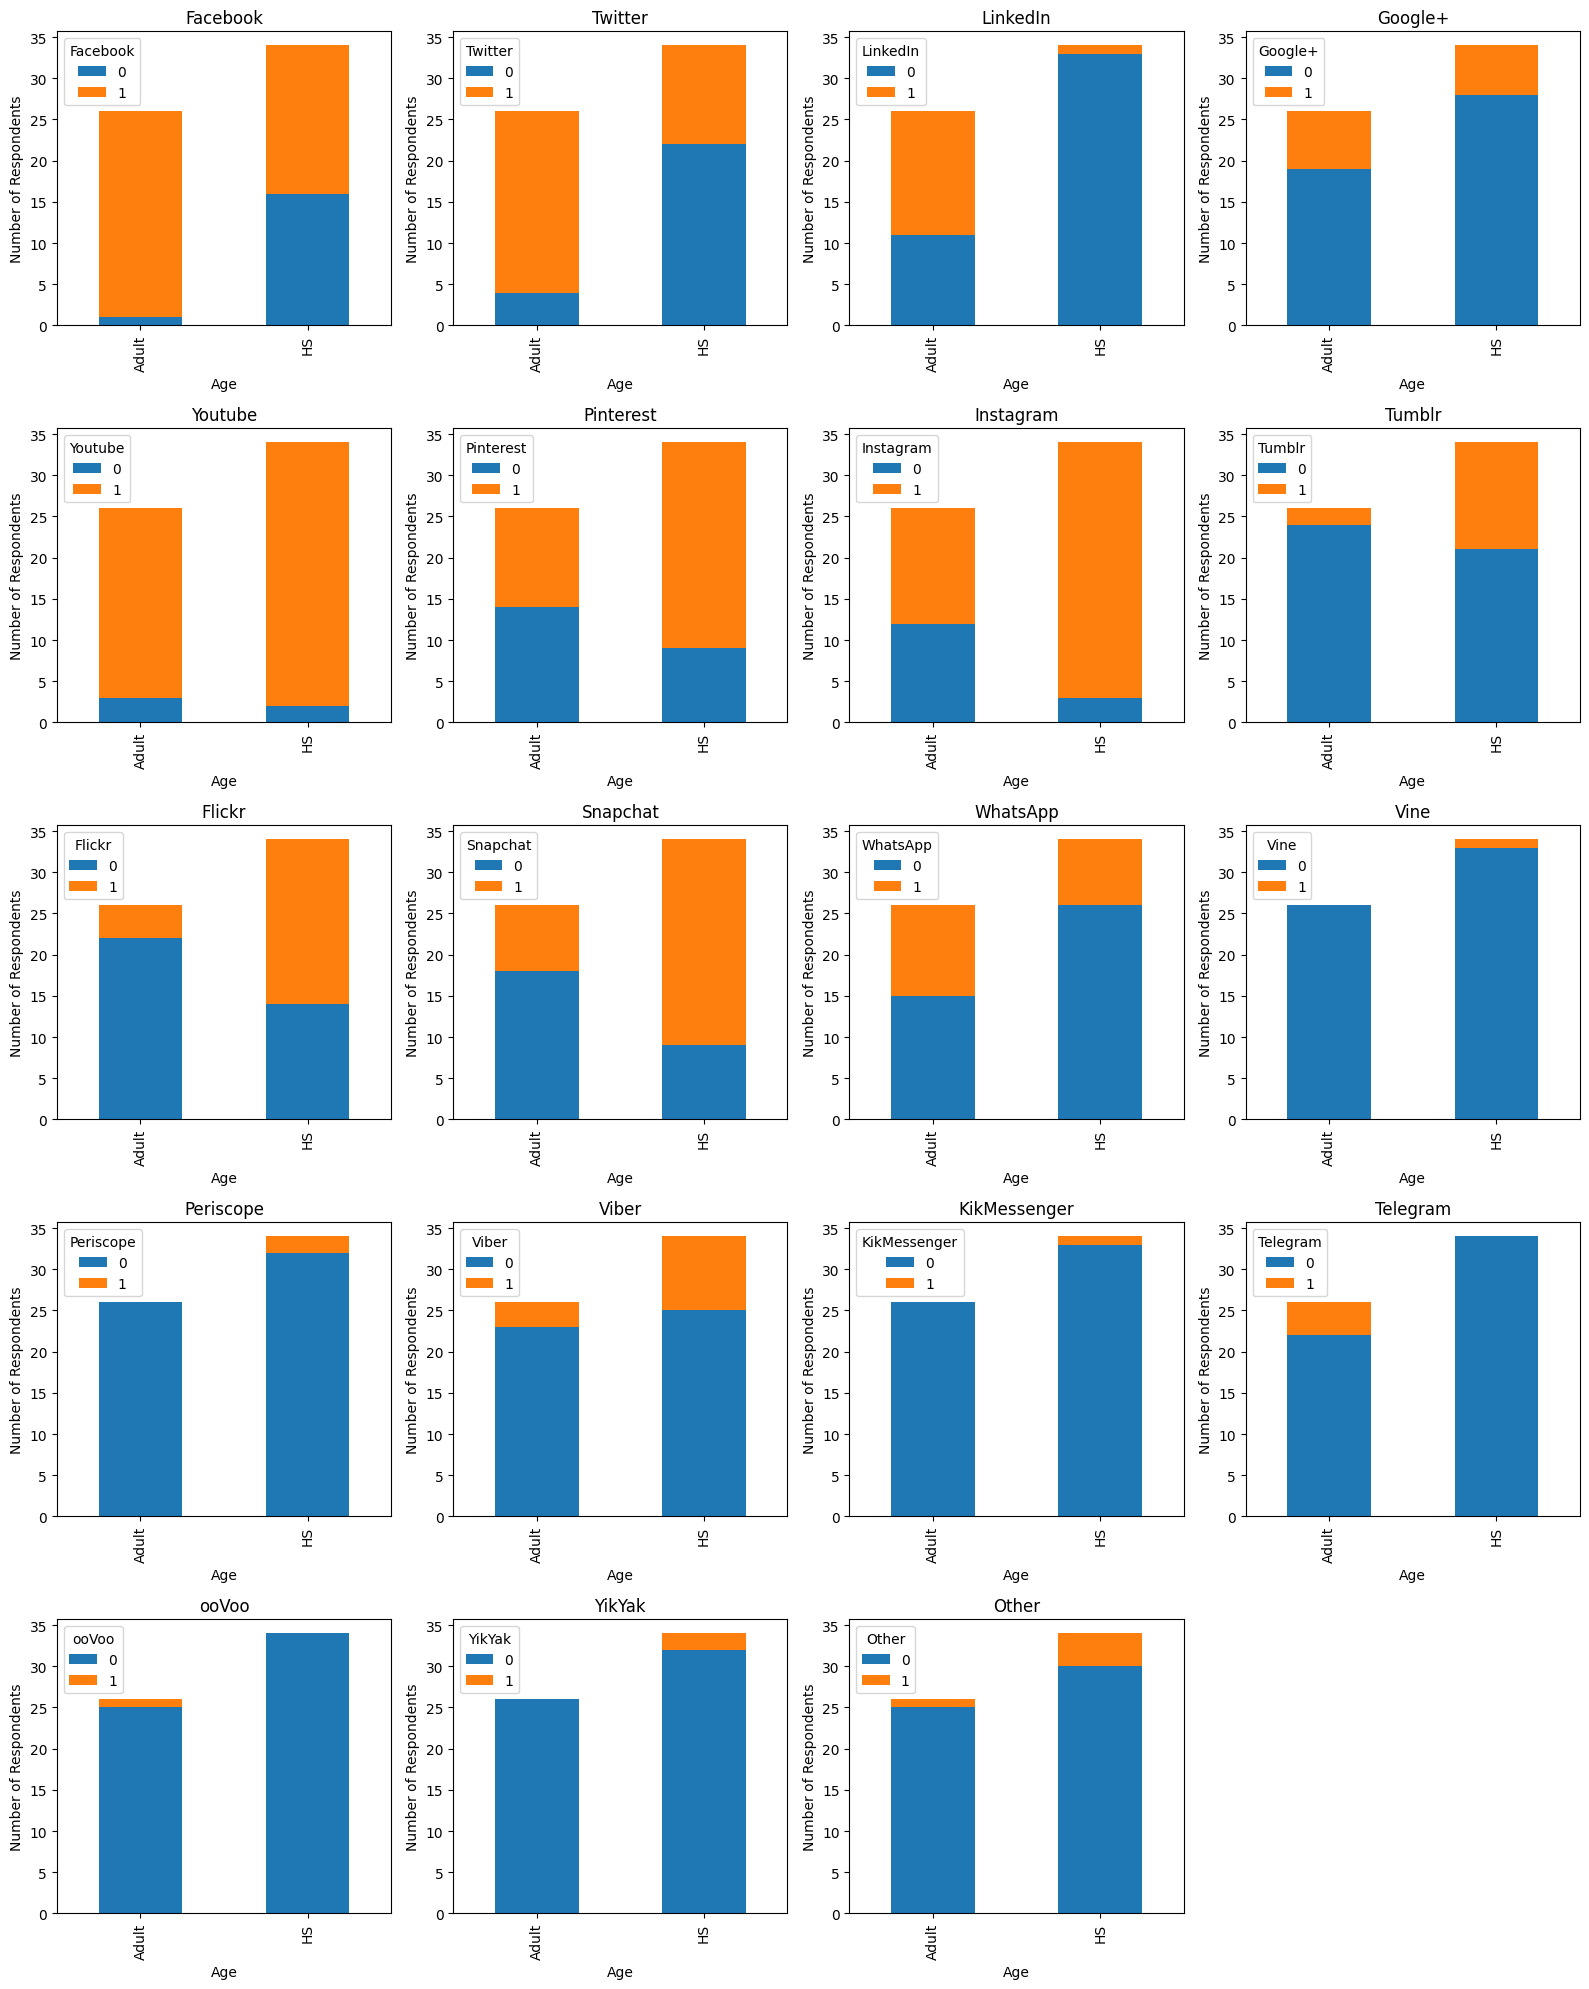

In [ ]:
platforms = sm.columns[:-1] # listing all social media platforms
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(16, 20), sharex=False, sharey=False)  # Creating small multiples figures and Turning off shared axes
for i, platform in enumerate(platforms):
    group = sm.groupby('Age')[platform].value_counts().unstack(fill_value=0) #grouping by age
    group.plot(kind='bar', ax=axs[i // 4, i % 4], stacked=True)  # Selecting subplot using row and column index
    axs[i // 4, i % 4].set_title(platform) #setting tiltle for each subplot using platform
    axs[i // 4, i % 4].set_xlabel('Age')#setting x label
    axs[i // 4, i % 4].set_ylabel('Number of Respondents')#setting y label
    axs[i // 4, i % 4].legend(title=platform)# setting legend
for i in range(len(platforms), len(axs.flatten())):
    fig.delaxes(axs[i // 4, i % 4])
plt.tight_layout()
plt.show()


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
X = sm.drop(columns='Age')
y = sm['Age']
clf = DecisionTreeClassifier() # Creating an instance of DecisionTreeClassifier
clf.fit(X,y) # Fitting the decision tree model to the data



DecisionTreeClassifier()

In [ ]:
!pip install graphviz

<function matplotlib.pyplot.show(close=None, block=None)>

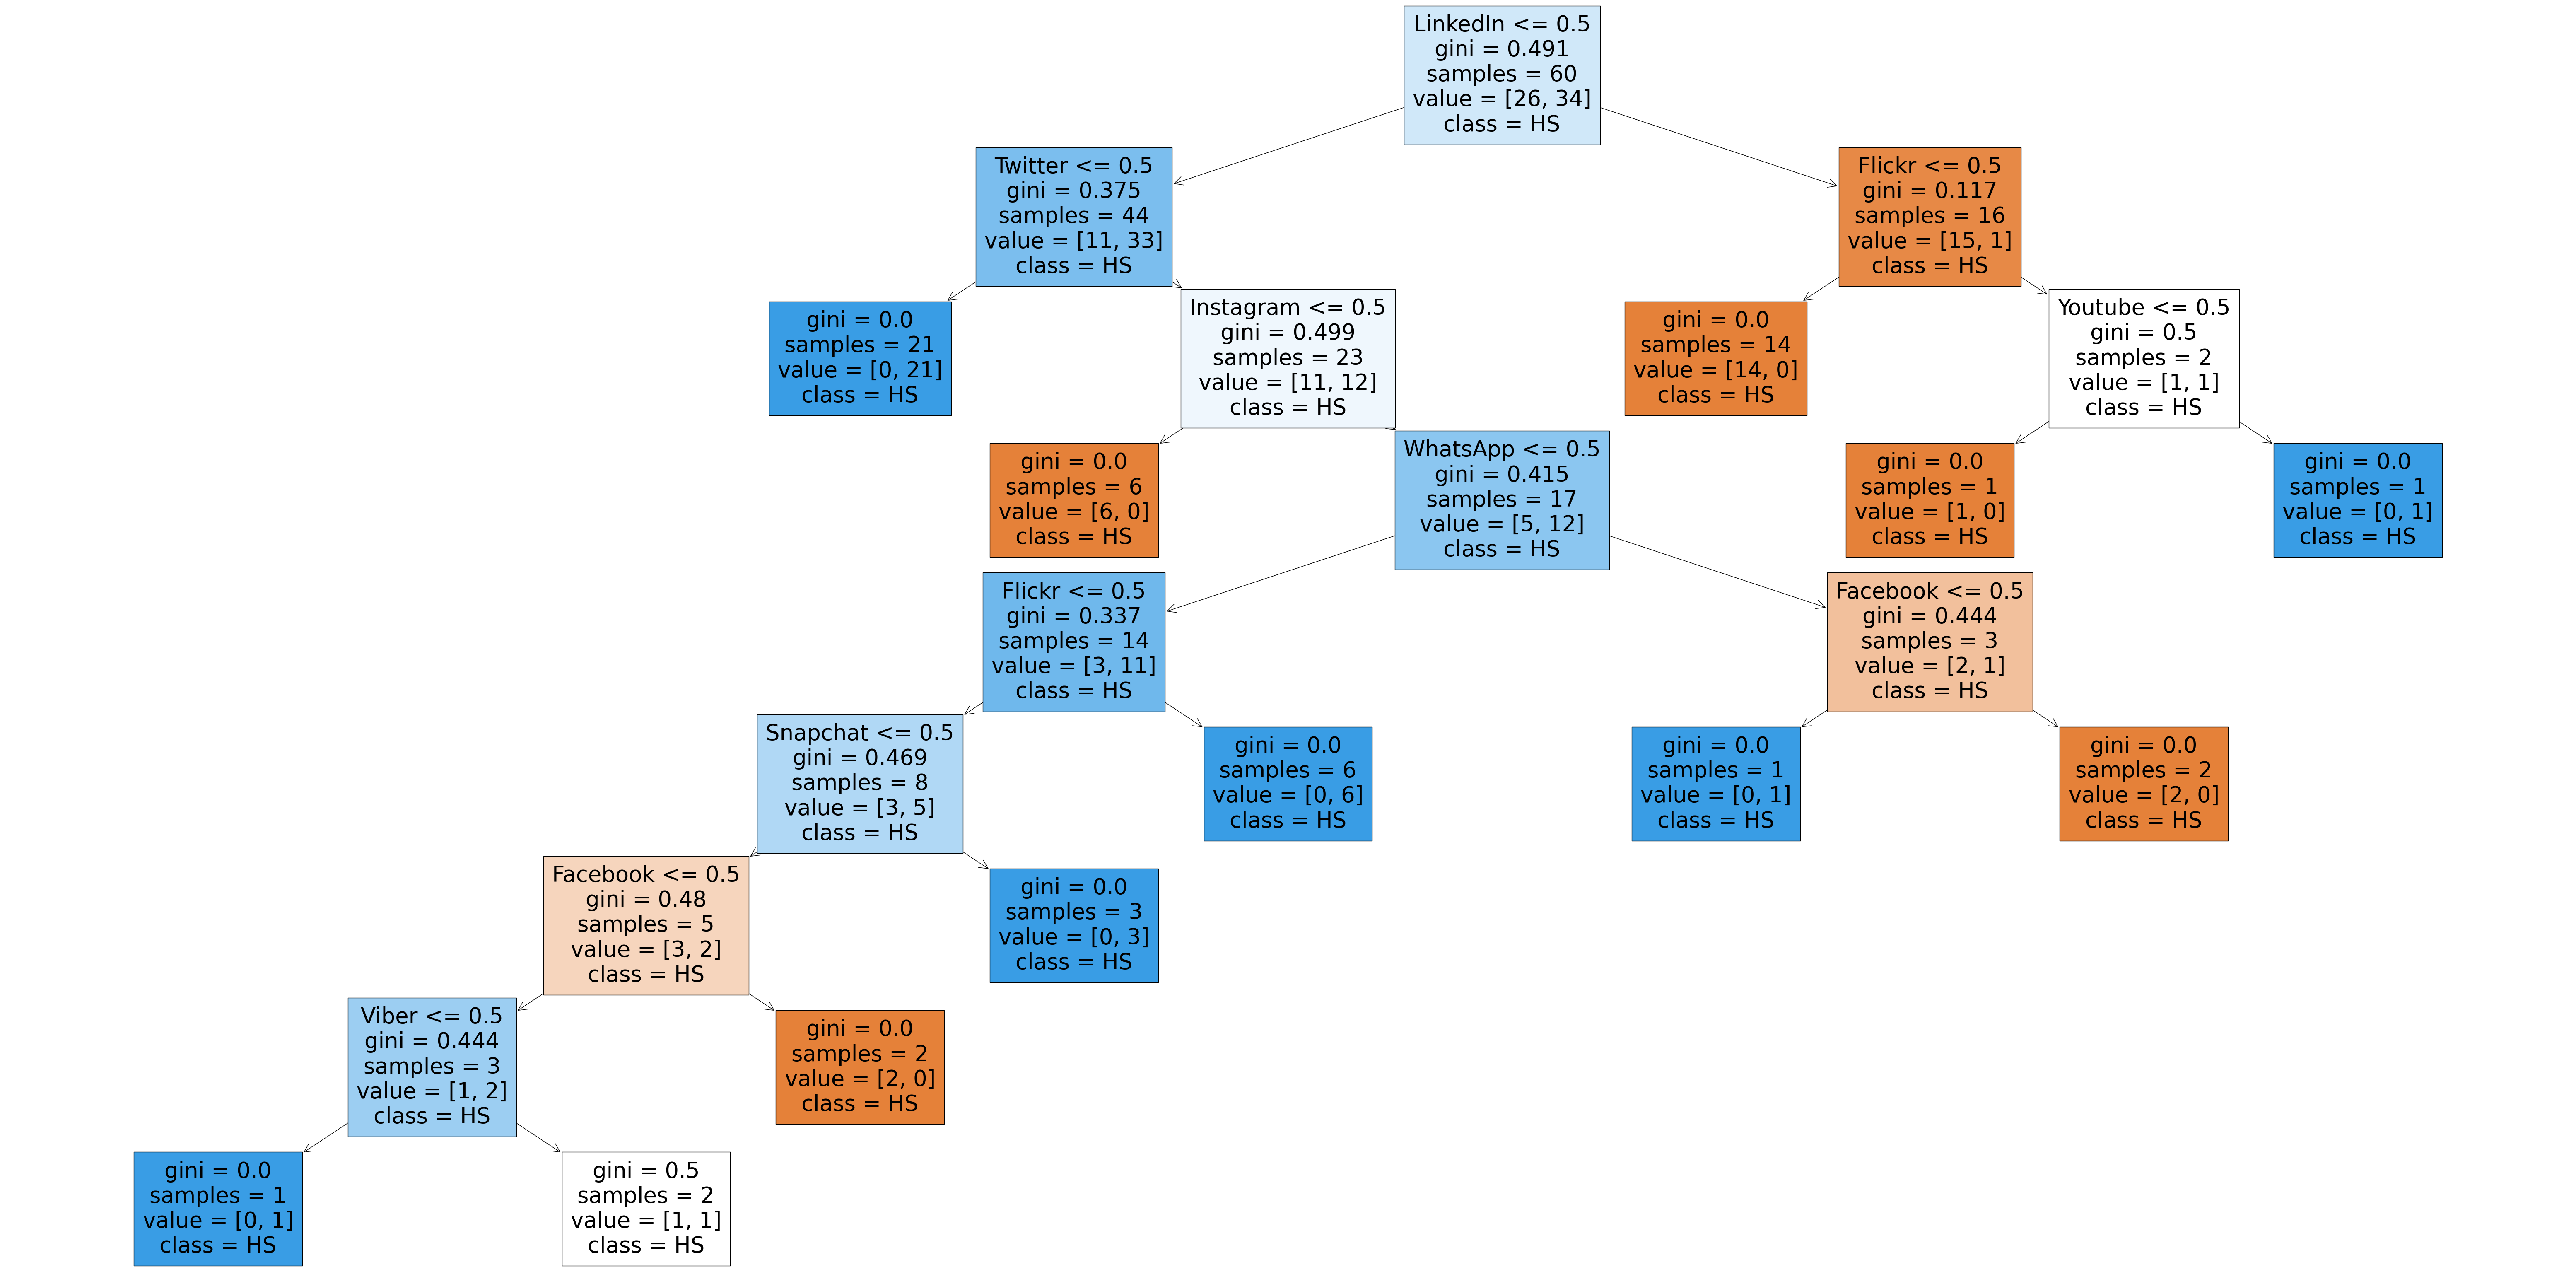

In [ ]:
import graphviz
plt.figure(figsize=(80,40)) # setting figure size
plot_tree(clf,feature_names = X.columns, class_names = y, filled = True) #Plotting the tree using the plot_tree where we also fill it with colors
plt.show

## 1 - Hold-out set

Let's start with a simplisted approach to model evaluation, split the data into training and testing data.  

<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/train_test_split_new.png" width="50%">


This is a common approach, but has multiple limitations.  First, there is the issue of model selection.  Most models have hyper-parameter, e.g., `n_neighbors` in KNN or kernel parameters of an SVM or we may also want to select among different models or algorithms.  A way to find a good parameter is to try different values and evaluate it on a test set.  Then, select the hyper-parameters performing best on the test set.  

<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/overfitting_validation_set_3.png" width="70%">

This assumes we know the "real" generalization performance for each hyper-parameter (this is only theoretically knowable).  What we have is the performance on the test set, which is a noisy version of the true generalization ability of the model.  If we pick the best performing hyper-parameters (red dot), it provides a good estimate of what the optimum hyper-parameter should be (the red dot is close to the maximum of the orange curve along the x-axis).  The accuracy on the test set is noisy, and the value selected (red dot) is overly optimistic.  *The test set accuracy is an unbiased estimate of generalization, but it's unbiased on average.  

Also, we have used the test set to select our hyper-parameter, we have no way of estimating the performance of the model with this hyper-parameter.


## 2 - Three-fold split or Train/Validation/Test set

Use of three separate sets:    
* the training set for model building
* the validation set for model selection
* the test set for final model evaluation
is probably the most common used method for model selection and evaluation. It is a **best practice** to follow (along with other techniques described below).

<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/train_test_validation_split.png" width="50%">

With this new approach, we use the validation set to select the optimum hyper-paramter and the test set to estimate the performance (accuracy).  Because the test set was not used for estimating the best hyper-parameter, the test set provides an unbiased estimate of the generalization performance. It is important to note, *the test set only provides an unbiased result if we are using it once**.  If we apply the selection procedure several times, comparing several test-set results and picking the best-performing model, we are in the exact same situation as above, and the estimate will be biased.





### Example of three-fold split

Let's see a simple example of using the three-fold split to select the number of neighbors in KNN on the iris data set.  We first take 25% as the test set, then take 25% of the remaining as the validation set (about ~19% of the original data).  

We build a model for each value of `n_neighbors` (range from 1-15 in steps of 2), evaluate it on the validation set and store the result.  We find the value which gives the best performance.

Then, we often rebuild the model on all the training data (train + validation) with the best-performing hyper-parameter (as determined by the validation set), and evaluate the model on the test set.

The step of retraining the model using bot the training and validation set is optional, in particular, if model training is very expensive or if the amount of training data is large enough for our model.  In this example problem, neither is the case so we retrain.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Load the data
X, y = load_iris(return_X_y = True)

# Split of the test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=25,
                                                          random_state=55)
# Split trainval into train + val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  test_size=25, random_state=5)

# create a list to hold the perf. results on validation set
val_scores = []
# specify hyper-parameter values
nbrs = np.arange(1,16,2)

for n in nbrs:
    # build a model
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    # calculate performance on validation set
    val_scores.append(knn.score(X_val, y_val))

# Find the best score and best hyper-parameter
print("best validation score:  %.3f" % np.max(val_scores))
best_nbrs = nbrs[np.argmax(val_scores)]
print("best n_neighbors: %d" % best_nbrs)

# Retrain model on train + validation set
knn = KNeighborsClassifier(n_neighbors=best_nbrs)
knn.fit(X_trainval, y_trainval)
print("test-set score: %.3f" % knn.score(X_test, y_test))

best validation score:  1.000
best n_neighbors: 5
test-set score: 0.960


This approach has improved upon the hold-out set method, but still relies on the particular splits.  What is we change the random splits, we might end up with different results.  In fact, if we see different outcomes based on our splits, it may mean the model is not very robust or there is not enough data.  *How can we make it more robust?*  Cross-validation

## 3 - K-fold cross-validation

The basic premise of cross-validation is to replace the split into training and validation data with multiple different splits.  Most commonly, cross validation is applied to the training/validation split, but it can also be applied to splitting off the test data.

<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/cross_validation_new.png" width="50%">

The most common variant of cross-validation is k-fold cross validation, the image above illustrates a 5-fold cross-validation.  

For each fold, a split of the data is made where this fold is the validation data, and the rest is the training data.  For the 5-fold cross-validation, we split the data into five parts, and have 5 different training/validation splits.  We build a model for each of the splits using the training part and validation part to evaluate it.  The outcome is five different performance values.  These can be aggregated - compute a mean/median, or use them to estimate a variance over the splits.  

This approach is more robust over using a single split.  All of the initial train/validation data is used in the validation set exactly once, where a single split only some of the data appears in the validation set.   The main disadvantage of cross-validation is the computational cost.  

Another issue of k-fold cross-validation is that it doesn't produce a model, it produced k models.  If you want to make predictions on new data, how to do so?  One obvious method is to retrain on the whole train/validation set.




### Example of cross-validation

There are two functions in `scikit-learn` for performing cross-validation: `cross_val_score` and `cross_validate`.  The `cross_val_score` has a very simple interface and the `cross_validate` provides more options.

We can use them to evaluate KNN on the iris data set.  Cross-validation is usually use to replace the inner split into training and validation set.  Both functions, take the estimator to evaluate (our knn), the data, the target and the number of folds.  The result of `cross_val_score` is an array with the accuracy for each validation sets.

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate

scores = cross_val_score(KNeighborsClassifier(), X_trainval, y_trainval, cv=10)
scores

array([1.        , 0.92307692, 1.        , 1.        , 0.92307692,
       0.91666667, 0.91666667, 1.        , 0.91666667, 1.        ])

We can also use `cross_validate`.  Here the result is a dictionary.

In [ ]:
# the number of folds defaults to 5
cv_result = cross_validate(KNeighborsClassifier(), X_trainval, y_trainval)
cv_result


{'fit_time': array([0.00123191, 0.00112343, 0.00111055, 0.00117636, 0.00120044]),
 'score_time': array([0.00977278, 0.00511312, 0.00911546, 0.00474405, 0.01085567]),
 'test_score': array([0.96, 1.  , 0.92, 0.96, 0.96])}

In [ ]:
# We can conver the dictionary to a Data Frame
pd.DataFrame(cv_result)

,fit_time,score_time,test_score
0,0.001232,0.009773,0.96
1,0.001123,0.005113,1.00
2,0.001111,0.009115,0.92
3,0.001176,0.004744,0.96
4,0.001200,0.010856,0.96


Both `cross_val_score` and `cross_validate` can use other evaluation metrics.

We can also go back and do cross-validation by hand, i.e., using the `KFold()` family of methods.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

# Load the data
X, y = load_iris(return_X_y = True)

# Split of the test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=25,
                                                          random_state=12)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=124)

scores = []

for tr_indx, val_indx in kf.split(X_trainval, y_trainval):
    X_train, X_val = X_trainval[tr_indx], X_trainval[val_indx]
    y_train, y_val = y_trainval[tr_indx], y_trainval[val_indx]

    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    scores.append(metrics.accuracy_score(y_val, y_pred))

print("mean validation score:  %.3f" % np.mean(scores))

mean validation score:  0.977


## 4 - Grid Search with Cross-validation in Validation Split

Let's now think about doing model selection, but using cross-validation rather than a single split.  The overall idea is illustrated below. We still have the initial split into training and test data.  But rather than a single split into training and validation data, we run cross-validation for each parameter setting.  We record the mean score averaged over the splits in the cross-validation.  After evaluating all candidate paramters, find the one with the best mean performance.  *Keep in mind this score does not correspond to a single model; there is no best model*.  We select the hyper-parameter that is best on average over the splits.  Then we build a new model, using the hyper-parameters that performed best on average in cross-validation, on the full training dataset (X_trainval).  Finally, we evaluate this model on the test data set.   


<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/grid_search_cross_validation_new.png" width="60%">

<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/cv.png" width="60%">

In [ ]:
# Split of the test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=20,
                                                          random_state=55)

# create a list to hold the perf. results on validation sets
cross_val_scores = []
# specify hyper-parameter values
nbrs = np.arange(1,16,2)

for n in nbrs:
    # build the model with hyper-parameters
    knn = KNeighborsClassifier(n_neighbors=n)
    # Instead of fitting a single model, we perform cross-validation
    scores = cross_val_score(knn, X_trainval, y_trainval, cv=10)
    # record the average over the 10 folds
    cross_val_scores.append(np.mean(scores))

print(f"best cross-validation score: {np.max(cross_val_scores):.3}")
best_nbrs = nbrs[np.argmax(cross_val_scores)]
print(f"best n_neighbors: {best_nbrs}")

knn = KNeighborsClassifier(n_neighbors=best_nbrs)
knn.fit(X_trainval, y_trainval)
print(f"test-set score: {knn.score(X_test, y_test):.3f}")

best cross-validation score: 0.977
best n_neighbors: 9
test-set score: 1.000


The code above of grid-search with cross-validation and a hold-out test set is a gold standard approach for model comparison and parameter tuning.  

**ASIDE: Cross-validation vs. Grid Search**

Students over conflate the use of cross-validation with the use of grid search.  These are distinct and should not be used interchangeably.  Cross-validation is a technique to robustly evaluate a particular model on a particular data set.  Grid search is a technique to tune the hyper-parameters of a particular model by brute-force search.  Often each candidate is evaluated using cross-validaiton, but it is not necessary (you could use a single split of training + validation set).  So while cross-validation is often used within a grid search, you can also do cross-validation outside of a grid search, and you can do a grid search without using cross-validation.

The overall approach is illustrated below.  Start by specifying hyper-parameters to evaluate (generally this means selecting the models we are using as well).  Split the data into training and test sets.  For each hyper-parameter candidate, run a grid search on the training set, yielding a score for each split, and a mean score over all splits.  The mean validation scores are used to select the best hyper-parameter value and retrain a model on the whole training data.  Then we evaluate this final model on the test set.


<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/gridsearch_workflow.png" width="60%">
Image from scikit-learn.

<br>

This pattern of evaluation is common, therefore, `scikit-learn` has a method `GridSearchCV`, which does most of this for you.




## 5 - GridSearchCV

The `GridSearchCV` class is a meta-estimator, it takes any scikit-learn model and tunes the hyper-parameters for you using cross-validation.  The hyper-parameter grid is specified as a dictionary where the keys are the names of the parameters in the estimator and the values are all the candidate values of the hyper-parameter we want to evaluate.  

In [ ]:
from sklearn.model_selection import GridSearchCV

# Split of the test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=20,
                                                          random_state=55)

# define the parameter grid
param_grid = {'n_neighbors': np.arange(1, 16, 2)}

# Instantiate GridSearchCV - sets up the parameters on how to run
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10,
                    return_train_score=True)
# Execute the search (and retrain the final model)
grid.fit(X_trainval, y_trainval)

print(f"best mean cross-validation score: {grid.best_score_}")
print(f"best parameters: {grid.best_params_}")

# do a final evaluation on the test set
print(f"test-set score: {grid.score(X_test, y_test):.3f}")

best mean cross-validation score: 0.976923076923077
best parameters: {'n_neighbors': 9}
test-set score: 1.000


Because grid search is a meta-estimator, after you instantiate it, you can use it like any other scikit-learn model: use `fit`, `predict`, `score` methods using the best hyper-parameter setting.

The test set is reserved for the final evaluation, therefore, it can be a good idea to look at the search results without the test set.  If the `best_score_` is lower than expected or needed for an application, do not use the test set.  Also, you may want to look at whether the `best_params_` value is on the boundary of the search space specified.  If it is, you may want to extend the range.  Also, the model that was refit on the whole training + validation data (the model used when calling `predict` and `score`) is called as `best_estimator_`.  

The `cv_results_` attribute allow us to dive into the results.

In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.0027518 , 0.00126238, 0.00133922, 0.00116537, 0.0009691 ,
        0.00088429, 0.00076208, 0.00089324]),
 'std_fit_time': array([4.72658092e-03, 6.18781420e-04, 4.29381846e-04, 9.69171055e-05,
        2.69491641e-04, 2.71996897e-04, 1.10180611e-04, 2.24386041e-04]),
 'mean_score_time': array([0.00691843, 0.00374603, 0.00389853, 0.00412385, 0.00315523,
        0.00295594, 0.00267384, 0.00324748]),
 'std_score_time': array([0.00533586, 0.00067686, 0.00021045, 0.00074994, 0.00069574,
        0.00089455, 0.00044373, 0.00072332]),
 'param_n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11, 13, 15],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 7},
  {'n_neighbors': 9},
  {'n_neighbors': 11},
  {'n_neighbors': 13},
  {'n_neighbors': 15}],
 'split0_test_score': array([1., 1., 1., 1., 1., 1., 1

Each splits, training and testing score is returned because it was specified that `return_train_score=True`.  For a single hyper-parameter, we can plot the results.

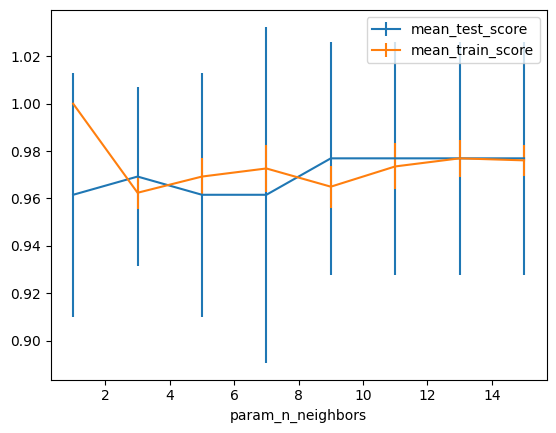

In [ ]:
results = pd.DataFrame(grid.cv_results_)
ax = results.plot('param_n_neighbors', 'mean_test_score', yerr='std_test_score')
# reuse the axes from the first plot (ax=ax)
results.plot('param_n_neighbors', 'mean_train_score', yerr='std_train_score', ax=ax)
plt.legend()

The wide standard deviation on the validation sets (test_score) is not suprising because of the small size of the data set.  

## 6 - Nested Cross-Validation

As mentioned above, it is most common to use cross-validation in the training/validation part of a three-fold split: train/validationa/test split.  However, it can be used for both, resulting in **nested cross-validation**.  Nested cross-validation is easy to implement, but not commonly used for three reasons:

* computationally expensive, adds another loop
* it doesn't result in a single model, so it's hard to productionize
* it is harder to understand

Here we can see an example.

In [ ]:
param_grid = {'n_neighbors':  np.arange(1, 15, 2)}
# instantiate grid search
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10,
                   return_train_score=True)
# perform cross-validation on the grid-search estimator
# where each individual fit will internally perform cross-validation
res = cross_validate(grid, X, y, cv=5, return_train_score=True, return_estimator=True)

In [ ]:
pd.DataFrame(res)

,fit_time,score_time,estimator,test_score,train_score
0,1.106208,0.005223,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",0.966667,0.975000
1,1.329026,0.005013,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",1.000000,0.966667
2,1.412992,0.005138,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",0.933333,0.966667
3,1.591403,0.005047,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",0.966667,0.983333
4,2.563975,0.005771,"GridSearchCV(cv=10, estimator=KNeighborsClassi...",1.000000,0.966667


Before, we had 8 hyper-parameter values (odds between 1-15), and 10 cross-validation folds, and a final evaluation model, so 81 models were learned.  With the outer cross-validation loop, there are 405 models, which adds time.

Also, the outcome is five different scores, for each split.  However, these don't match to a single model, because the grid search may lead to different optimum parameters:

In [ ]:
[x.best_params_ for x in res['estimator']]

[{'n_neighbors': 9},
 {'n_neighbors': 7},
 {'n_neighbors': 3},
 {'n_neighbors': 7},
 {'n_neighbors': 11}]

In this case, there is not a model that can be immediately used on new data.  One solution is to create an ensemble model (combine the predictions from the individual GridSearchCV model and average the results).  

The results of the grid-search represent an estimate of how well a given model generalizes if the hyper-parameters are adjusted with grid search.  This can be used when comparing algorithms, is algorithm A better than algorithm B when both properly tuned?

Because of these reasons we are instead going to use the approach described in 4 and 5 above to select hyper-parameters and evaluate the models.

# Data Leakage

*Copied and adpated from MLmastery Data Leakage page.*

A very common error when using cross-validation data leakage. Data leakage is where information about the holdout dataset, such as a test or validation dataset, is made available to the model in the training dataset.   This is not a direct type of data leakage, where we would train the model on the test dataset. Instead, it is an indirect type of data leakage, where some knowledge about the test dataset, captured in summary statistics is available to the model during training. This can make it a harder type of data leakage to spot, especially for beginners.

For example, consider a problem where we want to normalize the data, that is, scale the data to a range of 0-1.  When we normalize the input variables, this requires that we first calculate the minimum and maximum values for each variable before using these values to scale the variables. The dataset is then split into train and test datasets, but the examples in the training dataset know something about the data in the test dataset; they have been scaled by the global minimum and maximum values, so they know more about the global distribution of the variable then they should.

This type of data leakage exists with almost any data preparation task, e.g., standardization or even imputation of missing values.  

*How to solve this issue?*  Data preparation must be fit on the training data set only.  More generally, the entire modeling pipeline must be prepared only on the training dataset to avoid data leakage. This might include data transforms, but also other techniques such feature selection, dimensionality reduction, feature engineering and more.

Let's see an example of this issue.

## Example of Data Leakage on Hold-out set

We will start with some synthetic data for a binary classification problem.

The naive approach for scaling the data is:    

1. Run scaling on the entire data set
2. Split the data into train/test
3. Train the model on train, evaluate on test

In [ ]:
# test classification dataset
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

# normalize the dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)
# fit the model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
accuracy = metrics.accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy*100))


Accuracy: 94.800


Let's look at how we should do the data preparation to avoid data leakage:    

1. Split the data into train/test
2. Run scaling, use train to set parameters, apply to both train and test
3. Train the model on train, evaluate on test

In [ ]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

# define the scaler
scaler = MinMaxScaler()
# fit on the training dataset
scaler.fit(X_train)
# scale the training dataset
X_train = scaler.transform(X_train)
# scale the test dataset
X_test = scaler.transform(X_test)

# fit the model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
accuracy = metrics.accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy*100))

Accuracy: 94.400


The model with data leakage has slightly better performance that that without. *note, this may change across random splits*.

## Example of Data Leakage in Cross Validation

Naive data preparation with cross-validation involves applying the data transform first, then using the cross-validation procedure.



In [ ]:
from sklearn import model_selection

# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

# normalize the dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# define the model
model = KNeighborsClassifier()

# define the evaluation procedure
cv = model_selection.RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model using cross-validation
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))

Accuracy: 94.800 (2.344)


Let's look at the correct way to do data preparation with cross-validation.
It requires that the data preparation method is prepared on the training set and applied to the train and test sets within the cross-validation procedure.




In [ ]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

kf = model_selection.RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state=1)

scores = []

for tr_indx, te_indx in kf.split(X, y):
    X_train, X_test = X[tr_indx], X[te_indx]
    y_train, y_test = y[tr_indx], y[te_indx]

    # normalize the dataset
    scaler = MinMaxScaler().fit(X_train)
    X_train_trans = scaler.transform(X_train)
    X_test_trans = scaler.transform(X_test)

    # define the model
    model = KNeighborsClassifier()
    model.fit(X_train_trans, y_train)
    yhat = model.predict(X_test_trans)

    scores.append(metrics.accuracy_score(y_test, yhat))

print(scores)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))

[0.96, 0.88, 0.99, 0.96, 0.94, 0.97, 0.94, 0.91, 0.96, 0.96, 0.93, 0.95, 0.94, 0.95, 0.93, 0.92, 0.98, 0.93, 0.98, 0.96, 0.95, 0.95, 0.94, 0.95, 0.93, 0.97, 0.98, 0.94, 0.91, 0.97]
Accuracy: 94.767 (2.376)


## Example of Data Leakage with GridSearchCV

Let's look at how we get data leakage when using GridSearchCV as discussed above.



In [ ]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

# Split of the test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

# Scale the data
scaler = MinMaxScaler()
X_trainval_sc = scaler.fit_transform(X_trainval)
X_test_sc = scaler.transform(X_test)

# Instantiate the model
knn = KNeighborsClassifier()

# params for Grid Search
params = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}

# Use GridSearchCV
grid = GridSearchCV(knn, params, cv=5, return_train_score=True)
grid.fit(X_trainval_sc, y_trainval)

print(f"best mean cross-validation score: {grid.best_score_}")
print(f"best parameters: {grid.best_params_}")

best mean cross-validation score: 0.9333333333333333
best parameters: {'n_neighbors': 3}


What's the problem?  The scaling uses the data in train+validation to set the parameters and apply the scaling to the test set.

The issue is with the GridSearchCV usage.  GridSearchCV will split the train+validation dataset into the train set and a validation set. See the image below from scikit-learn to illustrate this idea again.

<img src="https://pages.mtu.edu/~lebrown/un5550-f21/p6/gridsearchSV.png" width="60%">
Image from scikit-learn.

<br>

Within the cross-validation, the validation set should be treated as a temporary unseen test set.  Therefore, the scaler should not be fit using this data.

How do we solve data leakage in this case?

Use **pipelines**.



## Example of a Pipeline

[Pipelines](https://scikit-learn.org/stable/data_transforms.html) allow us to use a number of different dataset transformations, we may clean, preprocess, reduce, example of create feature representations.



### Pipeline on Hold-out set

Let's see an example of scaling the data using a pipeline.  From above, we have an example of data leakage.

```python
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

# normalize the dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)
# fit the model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
accuracy = metrics.accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy*100))
```

Here, we can run the corrected code to prevent data leakage and compare it to a pipeline.


In [ ]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

# split into train and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

# define the scaler
scaler = MinMaxScaler()
# fit on the training dataset
scaler.fit(X_train)
# scale the training dataset
X_train = scaler.transform(X_train)
# scale the test dataset
X_test = scaler.transform(X_test)

# fit the model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
accuracy = metrics.accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy*100))

Accuracy: 95.200


In [ ]:
from sklearn.pipeline import make_pipeline

# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

# Setup the pipeline
pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

# Execute the pipeline with the data
pipe.fit(X_train, y_train)

# evaluate the model
res = pipe.score(X_test, y_test)

# evaluate predictions
print('Accuracy: %.3f' % (res*100))

Accuracy: 94.400


### Pipeline with Cross-validation

In the table, below we can see how cross-validation with data leakage can be converted to a pipeline and also how we can eliminate data leakage when using for-loops for cross-validation and in a pipeline.

You will want to use the code on the right ("GOOD") in the future.


<table>
<tr>
<td>
 preprocessing before cross validation
</td>
<td>
 preprocessing within cross validation
</td>
</tr>
<tr>
<td>

```python
# BAD!
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(X)

scores = []
for tr_indx, te_indx in KFold().split(X_sc, Y):
    knn = KNeighborsClassifier().fit(X_sc[train], y[train])
    score = knn.score(X_sc[test], y[test])
    scores.append(score)
```
</td>
<td>

```python
# GOOD!
scores = []
scaler = MinMaxScaler()
for train, test in KFold().split(X, y):
    scaler.fit(X[train], y[train])
    X_sc_train = scaler.transform(X[train])
    knn = KNeighborsClassifier().fit(X_sc_train, y[train])
    X_sc_test = scaler.transform(X[test])
    score = knn.score(X_sc_test, y[test])
    scores.append(score)
```
</td>
</tr>
<tr>
<td>
 equivalent to:    
</td>
<td>
 equivalent to:    
</td>
</tr>
<tr>
<td>

```python
scaler = MinMaxScaler()
X_sc = scalar.fit_transform(X)
scores = cross_val_score(KNeighborsClassifier(), X_sc, y)
```
</td>
<td>

```python
pipe = make_pipeline(MinMaxScaler(),
                        KNeighborsClassifier())
scores = cross_val_score(pipe, X, y)
```
</td>
</tr>
</table>



In [ ]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
scores = cross_val_score(pipe, X, y)

print("Mean Acc: %.3f" % (np.mean(scores)))

Mean Acc: 0.947


### Pipeline with GridSearchCV

If you recall, `GridSearchCV` is passed an estimator and a dictionary of parameter values for tuning hyper-parameters.  We can pass a `Pipeline` as the estimator, but we need to adjust the process above to ensure the parameter tuning is applied to the correct step of the pipeline.  This is done by specifying the hyper-parameters within a pipeline, by using the name of the step of the pipeline, followed by the double underscore ('dunder'), followed by the name of the hyper-parameter.

So, when we create a pipeline and we want to tune the `n_neighbors` parameter of KNN, we need to use  `kneighborsclassifier__n_neighbors` as the hyper-parameter name.
Below is the example code.

In [ ]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=13,
                           n_redundant=7, random_state=20)

# Split of the test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

# create the pipeline
knn_pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

# create the parameter grid
# Pipeline hyper-parameters are specified as <step name>__<hyper-parameter name>
params = {'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}

# Instantiate the grid-search
grid = GridSearchCV(knn_pipe, params, cv=10)
# run the grid search are report results
grid.fit(X_trainval, y_trainval)

print(grid.best_params_)
print(grid.score(X_test, y_test))

{'kneighborsclassifier__n_neighbors': 3}
0.94


We can look at all the parameters with:    

In [ ]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

We could also tune parameters of the pre-processing step.  Here we are adding a feature selection step to choose only a percentage of the top features to be included in the model.


In [ ]:
from sklearn.feature_selection import SelectPercentile

# create a pipeline
select_pipe = make_pipeline(MinMaxScaler(), SelectPercentile(),
                            KNeighborsClassifier())

# create the search grid.
# Pipeline hyper-parameters are specified as <step name>__<hyper-parameter name>
param_grid = {'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9, 10, 13, 15],
              'selectpercentile__percentile': [1, 2, 5, 10, 50, 100]}

# Instantiate grid-search
grid = GridSearchCV(select_pipe, param_grid, cv=10)

# run the grid-search and report results
grid.fit(X_trainval, y_trainval)
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'kneighborsclassifier__n_neighbors': 3, 'selectpercentile__percentile': 100}
0.94


Note, we can make the parameter names of the GridSearch a bit simpler by using establishing some abbreviations.

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
                        ('sc', MinMaxScaler()),
                        ('fs', SelectPercentile()),
                        ('knn', KNeighborsClassifier())])

# create a pipeline
select_pipe = Pipeline([
                        ('sc', MinMaxScaler()),
                        ('fs', SelectPercentile()),
                        ('knn', KNeighborsClassifier())])

# create the search grid.
# Pipeline hyper-parameters are specified as <step name>__<hyper-parameter name>
param_grid = {'knn__n_neighbors': [1, 3, 5, 7, 9, 10, 13, 15],
              'fs__percentile': [1, 2, 5, 10, 50, 100]}

# Instantiate grid-search
grid = GridSearchCV(select_pipe, param_grid, cv=10)

# run the grid-search and report results
grid.fit(X_trainval, y_trainval)
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'fs__percentile': 100, 'knn__n_neighbors': 3}
0.94


### Different options in a Pipeline.

We may want the pipeline to select what preprocessing steps to include or what models to apply.  For example, I have been using `MinMaxScaler` in the examples, but what if instead we should use `StandardScaler` for this dataset.  We can let `GridSearchCV` answer this.


In [ ]:
from sklearn.preprocessing import StandardScaler

# declare a two step pipeline, explicitly giving names to both steps.
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# The name of the first step is 'scaler' and we can assign different
# estimators to this step, such as MinMaxScaler or StandardScaler
# There is a special value 'passthrough' which skips the step
param_grid = {'scaler': [MinMaxScaler(), StandardScaler(), 'passthrough'],
              # we named the second step knn, so we have to use that name here
              'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}

# instantiate and run as before:
grid = GridSearchCV(pipe, param_grid, cv=10)
grid.fit(X_trainval, y_trainval)
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'knn__n_neighbors': 5, 'scaler': StandardScaler()}
0.952


Remember, we can see the detailed results with `cv_results_` attribute.

In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.00175674, 0.00187631, 0.00099342, 0.0016937 , 0.0021769 ,
        0.00093532, 0.00178542, 0.00203633, 0.00089281, 0.00164165,
        0.0018558 , 0.00088155, 0.00164309, 0.00176635, 0.00082359,
        0.00150259, 0.00175762, 0.00091653, 0.00146127, 0.00171034,
        0.00083125, 0.0022356 , 0.00408778, 0.00175796]),
 'std_fit_time': array([3.60502642e-04, 1.06174130e-04, 1.62152367e-04, 2.70760770e-04,
        9.87801626e-04, 1.54330908e-04, 3.50990617e-04, 3.37888422e-04,
        4.09662580e-05, 1.77250134e-04, 5.31640073e-05, 3.32658857e-05,
        1.26638075e-04, 4.51307163e-05, 2.61259771e-05, 1.28932000e-04,
        3.84342286e-05, 2.26545299e-04, 1.08875144e-04, 4.09209984e-05,
        1.50771242e-05, 1.10256226e-03, 2.08361527e-03, 1.88692250e-03]),
 'mean_score_time': array([0.00775273, 0.00763731, 0.01087465, 0.00786755, 0.00815716,
        0.00735567, 0.00835819, 0.00837333, 0.00826967, 0.00746241,
        0.00762041, 0.00740168, 0.0101156 , 0.00

We can get even more advanced with our `GridSearchCV` options, because it can search over grids, and also over lists of grids (a list of dictionaries). This is useful when different pre-processing steps or models have different hyper-parameters. For example, say we wanted to tune whether the `MinMaxScaler` should scale between 0 and 1 or between -1 and 1, while also considering the case of using `StandardScaler`. We can't just add `feature_range` to the `param_grid` dictionary because `StandardScaler` doesn't have a `feature_range` parameter. Instead we can create a list of two grids: one grid that always uses `MinMaxScaler` and one that always uses `StandardScaler`. This is a bit of a contrived example, but once we know more models and transformers there will be plenty of cases where this comes in handy.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
param_grid = [
    {'scaler': [MinMaxScaler()],
     'feature_range': [(0, 1), (-1, 1)],
     'knn__n_neighbors': [1, 3, 5, 7, 9, 11]},
    {'scaler': [StandardScaler()],
     'knn__n_neighbors': [1, 3, 5, 7, 9, 11]}
]


Note, the values for scaler always need to be a list, even if it's a list with a single element. So we can't specify 'scaler': MinMaxScaler().

### Accessing attributes in grid-search pipeline

We may want to access information about the model.

For example, we can access the model fitted on the whole training+validation data using the `best_estimator_` attribute.

In [ ]:
grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    'passthrough']})

In [ ]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

You can see that best estimator is a pipeline itself.  We can also access an individual step.

In [ ]:
grid.best_estimator_['scaler']

StandardScaler()

This is a scaler that was fit on the whole training+validation dataset.

We can also access parameters that scaler uses, for example the min values used in the MinMaxScaler or the mean values used in the StandardScaler.

In [ ]:
grid.best_estimator_['scaler'].mean_

array([ 0.40896306,  0.36480057,  1.29951722, -0.0558038 ,  0.41304036,
        0.58007339, -0.46107616,  0.50317085, -0.11268126, -0.09956297,
        0.87089602, -0.71248985,  0.96428355, -1.07964908,  0.04909933,
        1.03999126, -1.50948237, -0.05674912,  0.61672511,  0.49217227])

# Problem 2. Classification - Music Hits

For this problem, you will work to classify a song’s popularity. Specifically, you will develop methods to predict whether a song will make the Top10 of Billboard’s Hot 100 Chart. The data set consists of song from the Top10 of Billboard’s Hot 100 Chart from 1990-2010 along with a sampling of other songs that did not make the list.  

The data source is the MIT 15.071 course. The data set was created by scraping Billboard’s Hot 100, other songs on Billboard, and using the EchoNest API, now a part of Spotify, to get song information.

The variables included in the data set include several description of the song and artist (including song title and id numbers), the year the song was released. Additionally, several variables describe the song attributes: time signature, loudness, tempo, key, energy pitch, and timbre (measured of different sections of the song). The last variable is binary indicated whether the song was in the Top10 or not.

You will use the variables of the song attributes (excluding the variables involving confidence in that attribute, e.g., key confidence) to predict whether the song will be popular or not.

In [ ]:
music = pd.read_csv("music.csv", sep=",", encoding = "ISO-8859-1") # reading music data
columns_to_remove = ['artistname', 'songtitle','artistID', 'songID','timesignature_confidence','tempo_confidence','key_confidence']
music = music.drop(columns=columns_to_remove) # remove columns not used in the analysis


In [ ]:
music.head()

,year,timesignature,loudness,tempo,key,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,...,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2010,3,-4.262,91.525,11,0.966656,0.024,0.002,57.342,-6.496,...,82.475,-52.025,39.116,-35.368,71.642,-126.440,18.658,-44.770,25.989,0
1,2010,4,-4.051,140.048,10,0.984710,0.025,0.000,57.414,-37.351,...,106.918,-61.320,35.378,-81.928,74.574,-103.808,121.935,-38.892,22.513,0
2,2010,4,-3.571,160.512,2,0.989900,0.026,0.003,57.422,-17.222,...,80.621,-59.773,45.979,-46.293,59.904,-108.313,33.300,-43.733,25.744,0
3,2010,4,-3.815,97.525,1,0.939207,0.013,0.000,57.765,-32.083,...,96.675,-78.660,41.088,-49.194,95.440,-102.676,46.422,-59.439,37.082,0
4,2010,4,-4.707,140.053,6,0.987738,0.063,0.000,56.872,-223.922,...,110.332,-56.450,37.555,-48.588,67.570,-52.796,22.888,-50.414,32.758,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = music.drop(columns=['Top10'])
y = music['Top10']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=5) # Splitting the dataset into training and testing sets
# Creating a pipeline for KNN classification
knn_pipeline = Pipeline([
    ('scaler', None),
    ('clf', KNeighborsClassifier())
])
#Defining parameters
parameters = {
    'clf__n_neighbors': [3, 7, 11, 15]
}
scalers = [('StandardScaler', StandardScaler()), ('MinMaxScaler', MinMaxScaler())]
result = [] # list to store results
for scaler_name, scaler in scalers:
    knn_pipeline.steps[0] = ('scaler', scaler) #adding scaler in the pipeline
    classification = GridSearchCV(knn_pipeline, parameters, cv=10, scoring='f1') #gridsearch to find best hyped parameters
    classification.fit(X_train_val, y_train_val)
    best_model = classification.best_estimator_ # searching for best model
    predict_y = best_model.predict(X_test) # Predicting the target variable on the test set using the best model
    accuracy = accuracy_score(y_test, predict_y) #caluculating accuracy
    precision = precision_score(y_test, predict_y) #caluculating prescion
    recall = recall_score(y_test, predict_y) # getting recall score
    f1 = f1_score(y_test, predict_y) #getting f1 score
    result.append(['KNN', scaler_name, classification.best_params_, accuracy, precision, recall, f1]) #adding result to the list

knn_df = pd.DataFrame(result, columns=['Model', 'Scaler', 'Best Hyperparameters', 'Accuracy', 'Precision', 'Recall', 'F1 Score']) # adding dataframe to store and display result
knn_df


,Model,Scaler,Best Hyperparameters,Accuracy,Precision,Recall,F1 Score
0,KNN,StandardScaler,{'clf__n_neighbors': 3},0.82058,0.462687,0.236641,0.313131
1,KNN,MinMaxScaler,{'clf__n_neighbors': 3},0.80343,0.378378,0.213740,0.273171


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = music.drop(columns=['Top10'])
y = music['Top10']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=5) # Splitting the dataset into training and testing sets
# Creating a pipeline for Decision Tree classification
decision_pipeline = Pipeline([
    ('scaler', None),
    ('clf', DecisionTreeClassifier())
])
#Defining parameters
parameters = {
    'clf__max_depth': [2, 4, 10]
}
scalers = [('StandardScaler', StandardScaler()), ('MinMaxScaler', MinMaxScaler())]
result = [] # list to store results
for scaler_name, scaler in scalers:
    decision_pipeline.steps[0] = ('scaler', scaler) #adding scaler in the pipeline
    classification = GridSearchCV(decision_pipeline, parameters, cv=10, scoring='f1') #gridsearch to find best hyped parameters
    classification.fit(X_train_val, y_train_val)
    best_model = classification.best_estimator_ # searching for best model
    predict_y = best_model.predict(X_test) # Predicting the target variable on the test set using the best model
    accuracy = accuracy_score(y_test, predict_y) #caluculating accuracy
    precision = precision_score(y_test, predict_y) #caluculating prescion
    recall = recall_score(y_test, predict_y) # getting recall score
    f1 = f1_score(y_test, predict_y) #getting f1 score
    result.append(['Decision Tree', scaler_name, classification.best_params_, accuracy, precision, recall, f1]) #adding result to the list

decision_df = pd.DataFrame(result, columns=['Model', 'Scaler', 'Best Hyperparameters', 'Accuracy', 'Precision', 'Recall', 'F1 Score']) # adding dataframe to store and display result
decision_df


,Model,Scaler,Best Hyperparameters,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,StandardScaler,{'clf__max_depth': 10},0.806069,0.388889,0.213740,0.275862
1,Decision Tree,MinMaxScaler,{'clf__max_depth': 10},0.804749,0.386667,0.221374,0.281553


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = music.drop(columns=['Top10'])
y = music['Top10']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=5) # Splitting the dataset into training and testing sets
# Creating a pipeline SVM  classification
svm_pipeline = Pipeline([
    ('scaler', None),
    ('clf', SVC(kernel='rbf'))
])
#Defining parameters
parameters = {
    'clf__C': [0.001, 0.1, 10]
}
scalers = [('StandardScaler', StandardScaler()), ('MinMaxScaler', MinMaxScaler())]
result = [] # list to store results
for scaler_name, scaler in scalers:
    svm_pipeline.steps[0] = ('scaler', scaler) #adding scaler in the pipeline
    classification = GridSearchCV(svm_pipeline, parameters, cv=10, scoring='f1') #gridsearch to find best hyped parameters
    classification.fit(X_train_val, y_train_val)
    best_model = classification.best_estimator_ # searching for best model
    predict_y = best_model.predict(X_test) # Predicting the target variable on the test set using the best model
    accuracy = accuracy_score(y_test, predict_y) #caluculating accuracy
    precision = precision_score(y_test, predict_y) #caluculating prescion
    recall = recall_score(y_test, predict_y) # getting recall score
    f1 = f1_score(y_test, predict_y) #getting f1 score
    result.append(['SVM', scaler_name, classification.best_params_, accuracy, precision, recall, f1]) #adding result to the list

svm_df = pd.DataFrame(result, columns=['Model', 'Scaler', 'Best Hyperparameters', 'Accuracy', 'Precision', 'Recall', 'F1 Score']) # adding dataframe to store and display result
svm_df


,Model,Scaler,Best Hyperparameters,Accuracy,Precision,Recall,F1 Score
0,SVM,StandardScaler,{'clf__C': 10},0.825858,0.493151,0.274809,0.352941
1,SVM,MinMaxScaler,{'clf__C': 10},0.844327,0.638298,0.229008,0.337079


In [ ]:
results = pd.concat([knn, decision_df,svm_df], axis=0)
results


,Model,Scaler,Best Hyperparameters,Accuracy,Precision,Recall,F1 Score
0,KNN,StandardScaler,{'clf__n_neighbors': 3},0.820580,0.462687,0.236641,0.313131
1,KNN,MinMaxScaler,{'clf__n_neighbors': 3},0.803430,0.378378,0.213740,0.273171
0,Decision Tree,StandardScaler,{'clf__max_depth': 10},0.806069,0.388889,0.213740,0.275862
1,Decision Tree,MinMaxScaler,{'clf__max_depth': 10},0.804749,0.386667,0.221374,0.281553
0,SVM,StandardScaler,{'clf__C': 10},0.825858,0.493151,0.274809,0.352941
1,SVM,MinMaxScaler,{'clf__C': 10},0.844327,0.638298,0.229008,0.337079


From the above observations, The models achieved moderate accuracy in the range of 80% to 85%. Among the models, SVM model with MinMaxScaler is better than KNN and Decision Tree models with accuracy of 84.4% and f1 score=0.337. KNN models exhibit consistent performance across scaling methods, but the choice of neighbors significantly affects results.Decision Tree models perform relatively poorer compared to SVM and KNN models, regardless of the scaling method used. Additionally, the choice of the maximum depth of the tree does not greatly impact the model's performance. Overall, SVM with MinMaxScaler and C=10 achieves the highest F1 score = 0.337, Accuracy=84.43%, Precision=63.9% indicating its effectiveness in predicting top-10 hits.

